In [67]:
# 크롤링에 필요한 라이브러리
import requests
from bs4 import BeautifulSoup

# 최신 기사 번호를 추출하기 위한 정규표현식
import re

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 형태소 분석
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# csv 저장을 위한 pandas
import pandas as pd

import time

### 기사 크롤링과 전처리
#### KBS World Radio 사이트에서 최근 n개 기사 제목과 내용 크롤링 후 전처리 
#### https://world.kbs.co.kr/service/news_list.htm?lang=e

- requests와 BeautifulSoup를 이용한 크롤링
- Regular Expression을 이용하여 텍스트 전처리

In [68]:
# 기사 목록 사이트에서 최신 기사 번호를 가져옴
# https://world.kbs.co.kr/service/news_list.htm

# 영어 사이트 기준 크롤링 코드
# 한국어 사이트는 html 구조가 다름
def get_latest_news_link(lang='e'):
    """기사 메인 사이트에서 최신 기사 버전 크롤링하는 함수 (기본 언어 : 영어)"""
    
    url = f'https://world.kbs.co.kr/service/news_list.htm?lang={lang}'
    
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    
    # 최신 기사가 있는 css selector에서 기사 링크를 가져옴
    selector = '#container > div > section.comp_contents_1x > article:nth-child(1) > h2 > a'
    select_res = soup.select(selector)

    # 기사 링크가 있는 href 속성
    # . 으로 시작하기 때문에 그 이후부터 추출
    news_link = select_res[0]['href'][1:]
    
    # 메인 사이트 url이랑 합쳐 최신 기사 링크 반환
    return news_link

In [69]:
def extract_news_num(news_link):
    """정규식을 이용하여 기사 url에서 기사 번호를 추출하는 함수"""
    
    # 숫자를 추출하는 정규식 패턴    
    num_pattern = re.compile('[0-9]+')

    # 기사 url에서 뉴스 기사 추출 -> 리스트로 반환 
    # 예시 url : ~/news_view.htm?lang=e&Seq_Code=177309
    news_num = num_pattern.findall(news_link)
    
    # 177309만 추출, 정수형으로 변환
    return int(news_num[0])

In [70]:
latest_news_link = get_latest_news_link()
latest_news_idx = extract_news_num(latest_news_link)

In [71]:
# news_cnt를 조절하면 그 수 만큼 크롤링 가능
def extract_n_th_news(latest_news_idx, news_cnt=20):
    """기사의 제목과 기사 내용을 추출하는 함수
    
    parameter:
    latest_news_idx : 최신 기사 번호
    news_cnt : 추출할 기사 개수
    """
    news_titles = []
    news_contents = []
    
    # 최신 기사 번호에서 1씩 감소해가며 크롤링
    for i in range(news_cnt):
        news_idx = latest_news_idx - i
        
        url = f'https://world.kbs.co.kr/service/news_view.htm?lang=e&Seq_Code={news_idx}'
        
        res = requests.get(url)
        soup = BeautifulSoup(res.text, 'html.parser')
        
        # 태그와 클래스 이름을 통해 기사 제목과 내용을 찾음
        title = soup.find('div', 
                          {'class' : 'title_area'}).get_text()
        
        content = soup.find('div',
                            {'class' : 'body_txt fr-view'}).get_text()
        
        news_titles.append(title)
        news_contents.append(content)
        
        time.sleep(0.5)
        
    return news_titles, news_contents
        
        

In [72]:
# 크롤링한 기사 제목과 기사 내용
titles, contents = extract_n_th_news(latest_news_idx)

In [73]:
def preprocess_titles_and_contents(titles, contents):
    """정규식을 이용하여 기사 제목과 컨텐츠에서 불필요한 문자를 제거하는 함수"""
    
    # 전체 기사 개수, 각 기사 제목과 본문마다 전처리 진행
    total_news_cnt = len(titles)
    
    # 기사 제목에서 작성 일자를 제거
    title_pattern = re.compile('(?<=\n)[^\n]+(?=\nWritten)')
    
    # 기사 내 사진 출처 텍스트 제거 정규식
    content_pattern = re.compile(r'\n*\s*Photo.*\n\s*')
    # 기타 개행문자 제거 정규식
    backslash_pattern = re.compile(r'[\r\n\xa0\u200b]+')
    # 문장부호 제거 정규식
    symbol_pattern = re.compile(r'[^\w\s]')
    
    # 전처리 결과 리스트
    preprocessed_titles = []
    preprocessed_contents = []
    
    for i in range(total_news_cnt):
        # i번째 기사 제목 추출
        title = title_pattern.findall(titles[i])[0]
        
        # i번째 기사 본문 사진 출처 텍스트 제거
        content = content_pattern.sub('', contents[i])
        # 출처를 제거한 텍스트에서 i번째 기사 개행문자 제거
        content = backslash_pattern.sub(' ', content)
        
        content = symbol_pattern.sub(' ', content)
        
        preprocessed_titles.append(title)
        preprocessed_contents.append(content)
        
    return preprocessed_titles, preprocessed_contents
        

In [74]:
preprocessed_titles, preprocessed_contents = preprocess_titles_and_contents(titles, contents)

### CSV 저장
#### 저장한 데이터를 판다스 데이터프레임화 후 csv로 저장
- pandas

In [75]:
# 전처리한 데이터를 데이터프레임으로 변환
news_df = pd.DataFrame({
    'title' : preprocessed_titles,
    'content' : preprocessed_contents
})

In [76]:
news_df

,title,content
0,Yellow Dust to Affect S. Korea over Weekend,Saturday will see mostly cloudy skies with hig...
1,'Biden to Pledge Steps to Shore Up Nuclear Det...,A senior U S official said Friday that Presid...
2,"Gas, Diesel Prices Rise Further This Week",Both gasoline and diesel prices rose this week...
3,BTS Suga's Solo Album Sets First-Day Sales Record,BTS member Suga has set a record for the bigge...
4,Yoon Orders Deployment of Cheonghae Naval Unit...,President Yoon Suk Yeol has ordered the deploy...
5,US Jury Orders Samsung to Pay $303 Mln in Pate...,A U S federal jury has deemed that Samsung El...
6,Sudan’s Paramilitary Forces to Partially Open ...,Sudan s paramilitary Rapid Support Forces RSF...
7,"US Says Will Coordinate with Allies, Partners ...",The U S State Department said it will contin...
8,Court Dismisses Arrest Warrant for Key Suspect...,A Seoul court has dismissed a warrant request ...
9,"S. Korea Attends Conference of NATO, Indo-Paci...",Seoul s deputy foreign minister for multilater...


In [77]:
# 현재 경로에 csv로 저장
news_df.to_csv('kbs_news_crawl_result.csv', index=False)

### 시각화 : 워드클라우드
#### 전처리한 기사 내용을 토대로 워드클라우드 시각화 진행
- nltk를 이용한 영어 형태소 분석
- wordcloud을 이용한 시각화

In [78]:
# 불용어 처리와 형태소 분석을 위한 코퍼스 데이터 다운로드
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\chanw\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\cha

True

In [79]:
# stopword(불용어) : 특별한 의미 없이 문법적 의미만 가진 단어 목록
stopword = stopwords.words('english')

In [80]:
# keyerror 방지 위해 defaultdict으로 사용
from collections import defaultdict

# 전체 단어 목록
total_words_counter = defaultdict(int)

# 각 전처리한 기사 내용에 대해 빈도수 계산 수행
for article in preprocessed_contents:
    
    # 전체 
    # 각 단어를 소문자화 후 불용어인지 확인, 아니라면 빈도수 추가
    tokenized_article = word_tokenize(article)
    for word in tokenized_article:
        word = word.lower()
        if word not in stopword:
            total_words_counter[word] += 1

In [81]:
sorted(total_words_counter.items(), reverse=True)

[('zero', 1),
 ('youtube', 1),
 ('young', 1),
 ('yoon', 13),
 ('yong', 1),
 ('yeol', 6),
 ('yellow', 1),
 ('years', 5),
 ('year', 4),
 ('yangyang', 1),
 ('xing', 1),
 ('wrote', 1),
 ('would', 5),
 ('worsened', 1),
 ('worldwide', 2),
 ('world', 1),
 ('working', 2),
 ('workers', 1),
 ('worked', 1),
 ('woon', 1),
 ('without', 1),
 ('wishes', 1),
 ('wire', 1),
 ('winds', 1),
 ('win', 1),
 ('willing', 1),
 ('willfully', 1),
 ('widely', 1),
 ('whose', 1),
 ('whether', 2),
 ('whereabouts', 1),
 ('went', 1),
 ('wenbin', 1),
 ('well', 1),
 ('welcomed', 1),
 ('welcome', 1),
 ('weeks', 1),
 ('week', 10),
 ('weather', 1),
 ('weapons', 2),
 ('weakened', 1),
 ('ways', 3),
 ('way', 1),
 ('waves', 1),
 ('waters', 4),
 ('water', 3),
 ('washington', 1),
 ('warrant', 1),
 ('war', 2),
 ('wang', 1),
 ('wake', 1),
 ('vowed', 1),
 ('vote', 1),
 ('visit', 2),
 ('violation', 2),
 ('violating', 1),
 ('vilnius', 2),
 ('views', 1),
 ('video', 1),
 ('victory', 1),
 ('victims', 4),
 ('vessel', 1),
 ('verdict', 1),


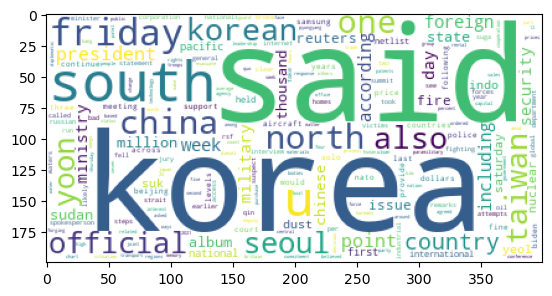

In [82]:
# 빈도수 딕셔너리 토대로 워드클라우드 시각화
wordcloud = WordCloud(
    background_color='white'
)

wordcloud.generate_from_frequencies(total_words_counter)

plt.imshow(wordcloud)